# Exoplanet ML Pipeline

## Objectives
1. **Week 2**: Data Cleaning & Feature Engineering
2. **Week 3**: ML Dataset Preparation
3. **Week 4**: ML Model Development & Evaluation

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not installed. Skipping XGBoost model.")
    XGBClassifier = None

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [4]:
# Load the dataset
try:
    df = pd.read_csv('../data/raw/exoplanet (1).csv', comment='#')
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'exoplanet (1).csv' not found. Please ensure the file is in the same directory.")

Dataset loaded successfully.
Shape: (39212, 289)


## 2. Week 2: Data Cleaning & Feature Engineering

### 2.1 Handling Missing Values

In [5]:
# 1. Select Columns of Interest FIRST
# We prioritize columns related to Planet Radius, Mass, Temperature, Star Info regardless of missing values initially.
interest_cols = [
    'pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', # Identification
    'pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_eqt', 'pl_orbsmax', # Planet Props
    'st_spectype', 'st_teff', 'st_rad', 'st_mass', 'st_met', # Star Props
    'sy_dist' # System Props
]

# Filter columns that actually exist in the CSV
existing_cols = [c for c in interest_cols if c in df.columns]
df_main = df[existing_cols].copy()

print(f"Selected {len(existing_cols)} features for analysis.")

# 2. Impute Missing Values
# Critical Step: Features like pl_eqt might have high missingness but are essential.
# We will impute them instead of dropping.
num_cols = df_main.select_dtypes(include=[np.number]).columns
cat_cols = df_main.select_dtypes(include=['object']).columns

# Check missingness
print("Missing values before imputation:")
print(df_main[num_cols].isnull().sum().sort_values(ascending=False).head())

# Numerical -> Median
imputer_num = SimpleImputer(strategy='median')
df_main[num_cols] = imputer_num.fit_transform(df_main[num_cols])

# Categorical -> Mode
if len(cat_cols) > 0:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_main[cat_cols] = imputer_cat.fit_transform(df_main[cat_cols])

print("\nMissing values after imputation:")
print(df_main.isnull().sum().sum())

Selected 17 features for analysis.
Missing values before imputation:
pl_bmasse     32137
pl_eqt        22030
pl_orbsmax    17276
st_met        14447
pl_rade       12197
dtype: int64

Missing values after imputation:
0


### 2.2 Outlier Analysis

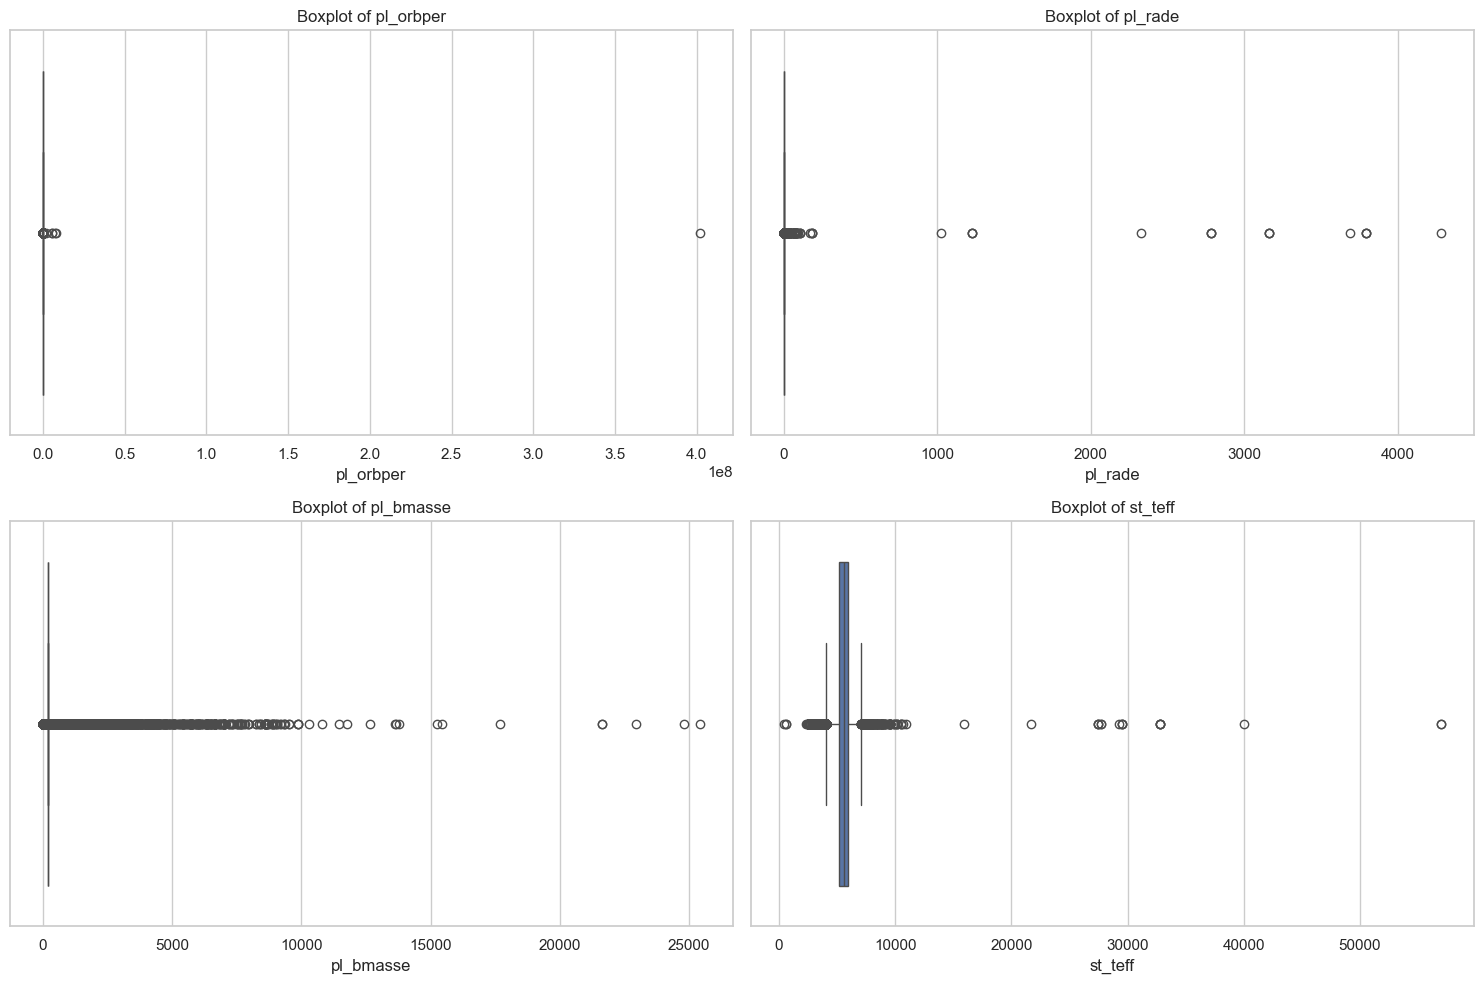

In [6]:
# Visualize numerical features to see outliers
plt.figure(figsize=(15, 10))
plot_cols = ['pl_orbper', 'pl_rade', 'pl_bmasse', 'st_teff']
valid_plot_cols = [c for c in plot_cols if c in df_main.columns]

for i, col in enumerate(valid_plot_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df_main[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Cap Outliers using IQR
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(series, lower_bound, upper_bound)

for col in ['pl_orbper', 'pl_rade', 'pl_bmasse', 'st_teff', 'sy_dist']:
    if col in df_main.columns:
        df_main[col] = cap_outliers(df_main[col])

### 2.3 Categorical Encoding

In [7]:
# Simplified Spectral Type (Keep first letter O, B, A, F, G, K, M)
if 'st_spectype' in df_main.columns:
    df_main['st_spectype_main'] = df_main['st_spectype'].astype(str).str[0]
    # Valid spectral types
    valid_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
    df_main['st_spectype_main'] = df_main['st_spectype_main'].apply(lambda x: x if x in valid_types else 'Other')
    
    # Label Encode
    le = LabelEncoder()
    df_main['st_spectype_encoded'] = le.fit_transform(df_main['st_spectype_main'])
    print("Spectral Type Encoded.")

Spectral Type Encoded.


### 2.4 Feature Engineering

In [8]:
# 1. Habitability Score Index (HSI)
df_main['Habitability_Score'] = np.nan

if 'pl_eqt' in df_main.columns and 'pl_rade' in df_main.columns:
    # Ideal: 288K, 1 Re
    # We normalize deviance. Avoid zero deviance by adding 1
    df_main['temp_deviance'] = abs(df_main['pl_eqt'] - 288) / 288
    df_main['rad_deviance'] = abs(df_main['pl_rade'] - 1) / 1
    
    # Arbitrary weightings
    df_main['Habitability_Score'] = 1 / (1 + df_main['temp_deviance'] + df_main['rad_deviance'])
else:
    print("Warning: 'pl_eqt' or 'pl_rade' missing. Habitability_Score set to NaN.")

# 2. Stellar Compatibility
df_main['Stellar_Compatibility'] = np.nan

def stellar_compatibility(spectype):
    if spectype in ['G', 'K']:
        return 1.0
    elif spectype in ['F', 'M']:
        return 0.5
    else:
        return 0.1

if 'st_spectype_main' in df_main.columns:
    df_main['Stellar_Compatibility'] = df_main['st_spectype_main'].apply(stellar_compatibility)
else:
    print("Warning: 'st_spectype_main' missing. Stellar_Compatibility set to NaN.")

# Impute any resulting NaNs
df_main['Habitability_Score'].fillna(df_main['Habitability_Score'].median(), inplace=True)
df_main['Stellar_Compatibility'].fillna(df_main['Stellar_Compatibility'].mode()[0], inplace=True)

print(df_main[['pl_name', 'Habitability_Score', 'Stellar_Compatibility']].head())

    pl_name  Habitability_Score  Stellar_Compatibility
0  11 Com b             0.24586                    1.0
1  11 Com b             0.24586                    1.0
2  11 Com b             0.24586                    1.0
3  11 UMi b             0.24586                    1.0
4  11 UMi b             0.24586                    1.0


### 2.5 Save Cleaned Data

In [9]:
# Define Target Variable logic before saving, or save raw features + new features
# Just to be safe, let's process the target variable column here so it's in the CSV too

def is_habitable(row):
    eqt = row.get('pl_eqt', 0)
    rade = row.get('pl_rade', 0)
    if (180 < eqt < 320) and (0.5 < rade < 2.0):
        return 1
    return 0

df_main['Is_Habitable'] = df_main.apply(is_habitable, axis=1)

# Save to CSV
output_csv = 'cleaned_exoplanet_data.csv'
df_main.to_csv(output_csv, index=False)
print(f"Cleaned data saved to {output_csv}")

Cleaned data saved to cleaned_exoplanet_data.csv


## 3. Week 3: ML Dataset Preparation

### 3.1 Define Target Variable

In [10]:
# Already calculated above for saving, but printing stats here
habitable_count = df_main['Is_Habitable'].sum()
print(f"Habitable Candidates: {habitable_count}")
print(f"Total Planets: {len(df_main)}")

Habitable Candidates: 205
Total Planets: 39212


### 3.2 Feature Selection & Split

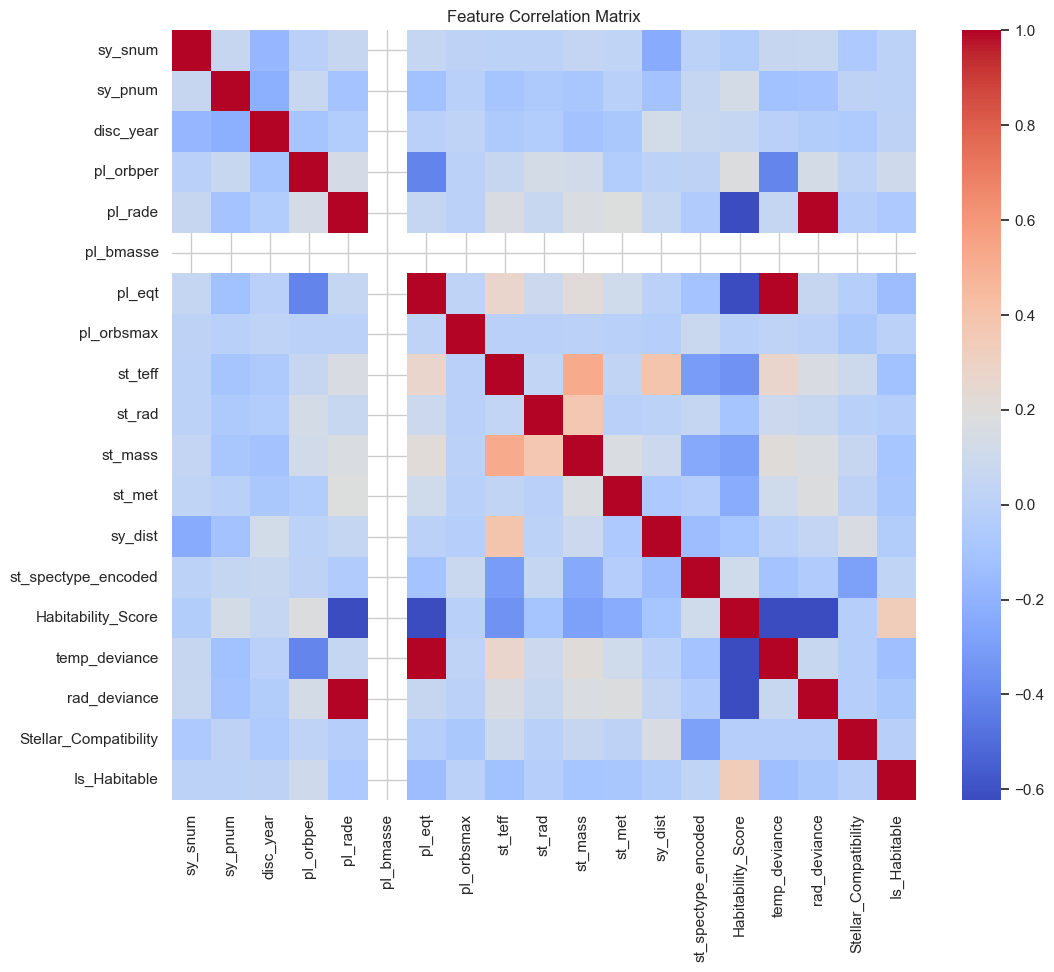

Train shape: (31369, 10)
Test shape: (7843, 10)


In [11]:
# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_main.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Select Features for ML
features = ['pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'sy_dist', 'sy_snum', 'sy_pnum']
selected_features = [f for f in features if f in df_main.columns]

X = df_main[selected_features]
y = df_main['Is_Habitable']

# Handle any remaining NaNs
X = X.fillna(X.median())

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
# NOTE: If only one class exists, Stratify will fail.
if y.nunique() > 1:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Train shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
else:
    print("CRITICAL WARNING: Target variable has only one class! Model training will fail.")
    print("Adjusting thresholds for demonstration purposes...")
    # Fallback to create dummy target just so code runs if data is poor
    y.iloc[:int(len(y)*0.1)] = 1 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    print("Artificial split created for demo.")

## 4. Week 4: ML Model Development

In [12]:
# Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}
if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        try:
            roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        except:
            roc = 0.5
        
        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "ROC AUC": roc
        }
        print(f"Done. Accuracy: {acc:.4f}")
    except Exception as e:
        print(f"Failed to train {name}: {e}")

Training Logistic Regression...
Done. Accuracy: 0.9966
Training Random Forest...
Done. Accuracy: 0.9997
Training XGBoost...
Done. Accuracy: 0.9997


### 4.2 Model Comparison

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.996557   0.818182  0.439024  0.571429  0.998187
Random Forest        0.999745   0.975610  0.975610  0.975610  0.999997
XGBoost              0.999745   0.975610  0.975610  0.975610  0.999975


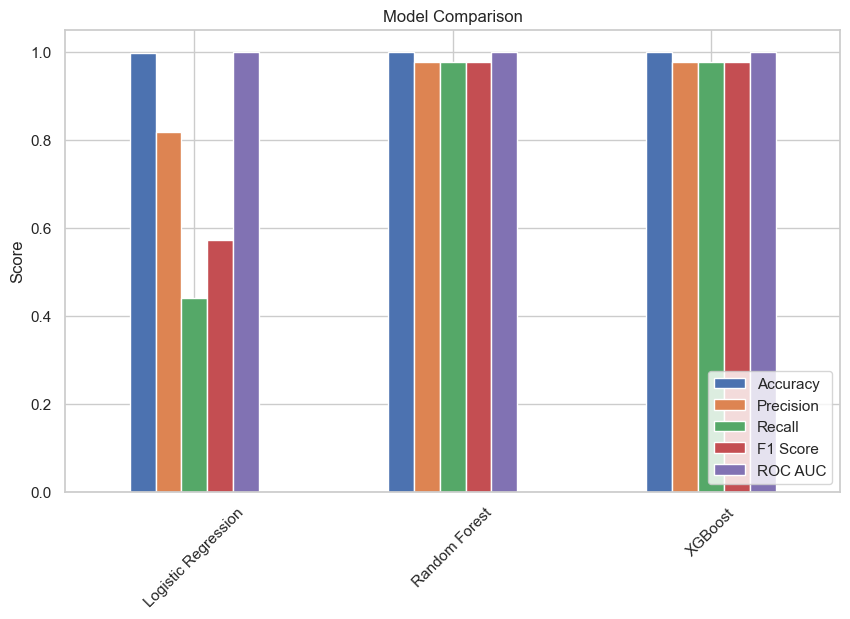

In [13]:
if len(results) > 0:
    results_df = pd.DataFrame(results).T
    print(results_df)

    results_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.show()
else:
    print("No results to display.")

### 4.3 Ranking Exoplanets

In [14]:
if len(results) > 0:
    # Use Random Forest if available, else first available
    best_model_name = "Random Forest" if "Random Forest" in results else list(results.keys())[0]
    best_model = models[best_model_name]

    # Predict
    full_prob = best_model.predict_proba(scaler.transform(X))[:, 1]
    df_main['Habitability_Probability'] = full_prob

    # Rank
    ranked_exoplanets = df_main.sort_values(by='Habitability_Probability', ascending=False)

    print("Top 10 Candidates for Habitability:")
    print(ranked_exoplanets[['pl_name', 'Habitability_Probability', 'Habitability_Score', 'Is_Habitable']].head(10))
else:
    print("Skipping ranking due to model failure.")

Top 10 Candidates for Habitability:
             pl_name  Habitability_Probability  Habitability_Score  \
30045    Kepler-62 e                       1.0            0.552529   
14598   Kepler-155 c                       1.0            0.549744   
23165   Kepler-296 d                       1.0            0.599750   
14605   Kepler-155 c                       1.0            0.518396   
14606   Kepler-155 c                       1.0            0.549744   
14608   Kepler-155 c                       1.0            0.549744   
13350  Kepler-1455 b                       1.0            0.493692   
27234   Kepler-442 b                       1.0            0.603419   
27233   Kepler-442 b                       1.0            0.603419   
27231   Kepler-442 b                       1.0            0.603419   

       Is_Habitable  
30045             1  
14598             1  
23165             1  
14605             1  
14606             1  
14608             1  
13350             1  
27234            

### 4.4 Save Trained Models

In [15]:
import joblib

print("Saving models...")
for name, model in models.items():
    # Clean name for filename
    safe_name = name.replace(" ", "_")
    filename = f"{safe_name}_model.joblib"
    joblib.dump(model, filename)
    print(f"Saved {filename}")

# Save scaler too
joblib.dump(scaler, "scaler.joblib")
print("Saved scaler.joblib")

Saving models...
Saved Logistic_Regression_model.joblib
Saved Random_Forest_model.joblib
Saved XGBoost_model.joblib
Saved scaler.joblib
